In [1]:
from utils import find_corners, stereo_calibration, \
                rmse_2D_detection, plot_rmse_dist, \
                undistort_rectify_save, \
                quaternion_to_transformation, calculate_BF_to_EN, \
                estimate_transform_average, rmse_2D_transform, rmse_3D_transform_plot, rmse_3D_disp_plot

from natsort import natsorted
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, cv2


In [2]:
# Loading Files
# Using rectified images
LEFT_PATH = "C:\\Users\\f007wsq\\Desktop\\datasets\\davinci_Xi_05282025\\XI_BIGDATA\\calibration_images\\cam1_cropped"
RIGHT_PATH = "C:\\Users\\f007wsq\\Desktop\\datasets\\davinci_Xi_05282025\\XI_BIGDATA\\calibration_images\\cam2_cropped"

LEFT_FILES = os.listdir(LEFT_PATH)
RIGHT_FILES = os.listdir(RIGHT_PATH)

IMG_SIZE = (894, 714)

In [3]:
with open("good_frames_L.txt", "r", encoding="utf-8") as f:
    LEFT_IMGS = [line.strip() for line in f]
print(LEFT_IMGS)
with open("good_frames_R.txt", "r", encoding="utf-8") as f:
    RIGHT_IMGS = [line.strip() for line in f]
print(RIGHT_IMGS)

# # Loading and Loading Images by Downsampling
# LEFT_IMGS = []
# for filename in LEFT_FILES:
#     if filename.endswith(".png"):
#         LEFT_IMGS.append(filename)
# LEFT_IMGS = natsorted(LEFT_IMGS)
# LEFT_IMGS = LEFT_IMGS[::6]
# print(LEFT_IMGS)

# RIGHT_IMGS = []
# for filename in RIGHT_FILES:
#     if filename.endswith(".png"):
#         RIGHT_IMGS.append(filename)
# RIGHT_IMGS = natsorted(RIGHT_IMGS)
# RIGHT_IMGS = RIGHT_IMGS[::6]
# print(RIGHT_IMGS)

['frame_4.png', 'frame_20.png', 'frame_24.png', 'frame_28.png', 'frame_36.png', 'frame_40.png', 'frame_44.png', 'frame_52.png', 'frame_60.png', 'frame_68.png', 'frame_72.png', 'frame_76.png', 'frame_84.png', 'frame_88.png', 'frame_96.png', 'frame_104.png', 'frame_108.png', 'frame_112.png', 'frame_120.png', 'frame_124.png', 'frame_128.png', 'frame_132.png', 'frame_136.png', 'frame_140.png', 'frame_148.png', 'frame_152.png', 'frame_156.png', 'frame_168.png', 'frame_176.png', 'frame_184.png', 'frame_196.png', 'frame_216.png', 'frame_232.png', 'frame_236.png', 'frame_240.png', 'frame_244.png', 'frame_248.png', 'frame_252.png', 'frame_260.png', 'frame_264.png', 'frame_268.png', 'frame_272.png', 'frame_276.png', 'frame_280.png', 'frame_284.png', 'frame_288.png', 'frame_292.png', 'frame_296.png', 'frame_300.png', 'frame_304.png', 'frame_308.png', 'frame_312.png', 'frame_320.png', 'frame_324.png', 'frame_328.png', 'frame_332.png', 'frame_340.png', 'frame_344.png', 'frame_348.png', 'frame_352.p

In [4]:
# Train/Test Split
import random
idxs = list(range(len(LEFT_IMGS)))
random.seed(42)
random.shuffle(idxs)
train_size = int(0.8 * len(LEFT_IMGS))
train_idxs = idxs[:train_size]
test_idxs = idxs[train_size:]
train_LEFT_IMGS = [LEFT_IMGS[i] for i in train_idxs]
train_RIGHT_IMGS = [RIGHT_IMGS[i] for i in train_idxs]
test_LEFT_IMGS = [LEFT_IMGS[i] for i in test_idxs]
test_RIGHT_IMGS = [RIGHT_IMGS[i] for i in test_idxs]
print("Train LEFT:", train_LEFT_IMGS)
print("Train RIGHT:", train_RIGHT_IMGS)
print("Test LEFT:", test_LEFT_IMGS)
print("Test RIGHT:", test_RIGHT_IMGS)   

Train LEFT: ['frame_380.png', 'frame_344.png', 'frame_264.png', 'frame_196.png', 'frame_340.png', 'frame_404.png', 'frame_504.png', 'frame_124.png', 'frame_384.png', 'frame_156.png', 'frame_444.png', 'frame_448.png', 'frame_128.png', 'frame_308.png', 'frame_104.png', 'frame_236.png', 'frame_428.png', 'frame_520.png', 'frame_60.png', 'frame_84.png', 'frame_412.png', 'frame_248.png', 'frame_320.png', 'frame_304.png', 'frame_508.png', 'frame_296.png', 'frame_20.png', 'frame_268.png', 'frame_272.png', 'frame_280.png', 'frame_232.png', 'frame_140.png', 'frame_120.png', 'frame_288.png', 'frame_416.png', 'frame_52.png', 'frame_240.png', 'frame_420.png', 'frame_24.png', 'frame_108.png', 'frame_260.png', 'frame_276.png', 'frame_136.png', 'frame_292.png', 'frame_148.png', 'frame_40.png', 'frame_44.png', 'frame_348.png', 'frame_468.png', 'frame_68.png', 'frame_364.png', 'frame_132.png', 'frame_464.png', 'frame_284.png', 'frame_72.png', 'frame_352.png', 'frame_300.png', 'frame_4.png', 'frame_332.p

In [5]:
# Chess board parameters
chessboard_size = (9, 6) # corners
square_size = 6 # mm
frame_size = (894, 714)

# Termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6)

# Prepare object points, like (0,0,0) (1,0,0) ...(6,5,0)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

In [6]:
imgpoints_L, imgpoints_R, objpoints, success_frames = find_corners(LEFT_PATH, RIGHT_PATH, train_LEFT_IMGS, train_RIGHT_IMGS, objp, chessboard_size)
criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
flags = 0
stereo_params = stereo_calibration(criteria=criteria_stereo, objpoints=objpoints, 
                                   imgpoints_L=imgpoints_L, imgpoints_R=imgpoints_R,
                                   K_L=None, D_L=None, K_R=None, D_R=None, 
                                   img_size=IMG_SIZE, flags=flags)

In [7]:
K_L = stereo_params['K_L']
D_L = stereo_params['D_L']
K_R = stereo_params['K_R']
D_R = stereo_params['D_R']

all_rmse_px_L, all_rmse_mm_L, dist_L, = rmse_2D_detection(objpoints, imgpoints_L, K_L, D_L)
all_rmse_px_R, all_rmse_mm_R, dist_R = rmse_2D_detection(objpoints, imgpoints_R, K_R, D_R)

In [8]:
print("RMSE Left (px):", np.mean(all_rmse_px_L))
print("RMSE Right (px):", np.mean(all_rmse_px_R))
print("RMSE Left (mm):", np.mean(all_rmse_mm_L))
print("RMSE Right (mm):", np.mean(all_rmse_mm_R))

RMSE Left (px): 0.20499016
RMSE Right (px): 0.16280541
RMSE Left (mm): 0.06338260736177521
RMSE Right (mm): 0.051001970487017746


In [9]:
# Calculate Undistortion and Rectification Remapping
R_L = stereo_params['R_L']
R_R = stereo_params['R_R']
P_L = stereo_params['P_L']
P_R = stereo_params['P_R']

mapL1, mapL2 = cv2.initUndistortRectifyMap(K_L, D_L, R_L, P_L, IMG_SIZE, cv2.CV_16SC2)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K_R, D_R, R_R, P_R, IMG_SIZE, cv2.CV_16SC2)

In [10]:
# Applying Mapping to all images and saving them
save_dir_L = os.path.join(os.path.dirname(LEFT_PATH), 'cam1_rect_train')
save_dir_R = os.path.join(os.path.dirname(RIGHT_PATH), 'cam2_rect_train')

os.makedirs(save_dir_L, exist_ok=True)
os.makedirs(save_dir_R, exist_ok=True)

for frame_name_L, frame_name_R in zip(train_LEFT_IMGS, train_RIGHT_IMGS):
    # Read and undistort left image
    imgL = cv2.imread(os.path.join(LEFT_PATH, frame_name_L))
    save_path_L = os.path.join(save_dir_L, frame_name_L)
    undistort_rectify_save(imgL, save_path_L, mapL1, mapL2)

    # Read and undistort right image
    imgR = cv2.imread(os.path.join(RIGHT_PATH, frame_name_R))
    save_path_R = os.path.join(save_dir_R, frame_name_R)
    undistort_rectify_save(imgR, save_path_R, mapR1, mapR2)

In [11]:
save_dir_L = os.path.join(os.path.dirname(LEFT_PATH), 'cam1_rect_test')
save_dir_R = os.path.join(os.path.dirname(RIGHT_PATH), 'cam2_rect_test')        
os.makedirs(save_dir_L, exist_ok=True)
os.makedirs(save_dir_R, exist_ok=True)  
for frame_name_L, frame_name_R in zip(test_LEFT_IMGS, test_RIGHT_IMGS):
    # Read and undistort left image
    imgL = cv2.imread(os.path.join(LEFT_PATH, frame_name_L))
    save_path_L = os.path.join(save_dir_L, frame_name_L)
    undistort_rectify_save(imgL, save_path_L, mapL1, mapL2)

    # Read and undistort right image
    imgR = cv2.imread(os.path.join(RIGHT_PATH, frame_name_R))
    save_path_R = os.path.join(save_dir_R, frame_name_R)
    undistort_rectify_save(imgR, save_path_R, mapR1, mapR2)

In [12]:
# Detecting Corners in Rectified and Undistorted Images
# Rectified paths
RECT_TRAIN_PATH_L = os.path.join(os.path.dirname(LEFT_PATH), 'cam1_rect_train')
RECT_TRAIN_PATH_R = os.path.join(os.path.dirname(RIGHT_PATH), 'cam2_rect_train')

imgpoints_L, imgpoints_R, objpoints, success_frames = find_corners(RECT_TRAIN_PATH_L, RECT_TRAIN_PATH_R, train_LEFT_IMGS, train_RIGHT_IMGS, objp, chessboard_size)

criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
# Force Distortion Coefficients to Zeros for Rectified Images
flags = (cv2.CALIB_FIX_K1 +
         cv2.CALIB_FIX_K2 +
         cv2.CALIB_FIX_K3 +
         cv2.CALIB_FIX_K4 +
         cv2.CALIB_FIX_K5 +
         cv2.CALIB_FIX_K6 +
         cv2.CALIB_ZERO_TANGENT_DIST) 

# stereo_params = stereo_calibration(criteria=criteria_stereo, objpoints=objpoints, 
#                                    imgpoints_L=imgpoints_L, imgpoints_R=imgpoints_R,
#                                    K_L=None, D_L=None, K_R=None, D_R=None, 
#                                    img_size=IMG_SIZE, flags=flags)

In [13]:
success_train_frames_L = [pair[0] for pair in success_frames]
success_train_frames_R = [pair[1] for pair in success_frames]

In [14]:
# Calculate BF_to_ENs using training set
# Load transformations collected by Polaris
OT_PATH = os.path.dirname(LEFT_PATH) + "\\transforms.csv"
OT_READINGS = pd.read_csv(OT_PATH)

P_L = stereo_params['P_L'][:3,:3]
P_R = stereo_params['P_R'][:3,:3]

# Define TF from CPcb to CPot
# CPcb: calibration plate checkerboard frame (origin at the top-left corner)
# CPot: calibration plate optical frame by ROM file (origin at the center of a sphere)
CPcb_to_CPot = np.array([[ 0,  1, 0, 54],
                          [ 1,  0, 0, 36],
                          [ 0,  0, -1, -8.132],
                          [ 0,  0, 0, 1]])

BF_to_EN_L_list, CPcb_to_EN_L_list, EN_to_CPcb_L_list, BF_to_CPcb_list = calculate_BF_to_EN(OT_READINGS, 
                                                                                            objpoints,
                                                                                            imgpoints_L,
                                                                                            success_train_frames_L,
                                                                                            CPcb_to_CPot,
                                                                                            P_L, D_L)

BF_to_EN_R_list, CPcb_to_EN_R_list, EN_to_CPcb_R_list, BF_to_CPcb_list = calculate_BF_to_EN(OT_READINGS, 
                                                                                            objpoints,
                                                                                            imgpoints_R,
                                                                                            success_train_frames_R,
                                                                                            CPcb_to_CPot,
                                                                                            P_R, D_R)

BF_to_EN_L_svd = estimate_transform_average(BF_to_CPcb_list, CPcb_to_EN_L_list)
BF_to_EN_L_avg = np.mean(np.array(BF_to_EN_L_list), axis=0)
BF_to_EN_L_std = np.std(np.array(BF_to_EN_L_list), axis=0)

BF_to_EN_R_svd = estimate_transform_average(BF_to_CPcb_list, CPcb_to_EN_R_list)
BF_to_EN_R_avg = np.mean(np.array(BF_to_EN_R_list), axis=0)
BF_to_EN_R_std = np.std(np.array(BF_to_EN_R_list), axis=0)

print(BF_to_EN_L_std)
print(BF_to_EN_R_std)

[[3.80789848e-03 8.73080613e-03 1.60114111e-02 4.29534758e+00]
 [1.61970897e-02 1.38971436e-02 3.15007072e-04 1.38094184e+00]
 [8.76905184e-03 3.83054960e-03 1.40992316e-02 3.91943044e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[3.80284659e-03 8.75329352e-03 1.51972549e-02 4.15572174e+00]
 [1.50670885e-02 1.45093818e-02 3.52758737e-04 1.34194433e+00]
 [8.78529975e-03 3.81802339e-03 1.43614264e-02 4.03069718e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [15]:
# find corners in test set
RECT_TEST_PATH_L = os.path.join(os.path.dirname(LEFT_PATH), 'cam1_rect_test')
RECT_TEST_PATH_R = os.path.join(os.path.dirname(RIGHT_PATH), 'cam2_rect_test')

imgpoints_L, imgpoints_R, objpoints, success_frames = find_corners(RECT_TEST_PATH_L, RECT_TEST_PATH_R, test_LEFT_IMGS, test_RIGHT_IMGS, objp, chessboard_size)

In [16]:
success_test_frames_L = [pair[0] for pair in success_frames]
success_test_frames_R = [pair[1] for pair in success_frames]

In [17]:
save_dir_L = os.path.join(os.path.dirname(LEFT_PATH), 'cam1_svd')
save_dir_R = os.path.join(os.path.dirname(RIGHT_PATH), 'cam2_svd')

os.makedirs(save_dir_L, exist_ok=True)
os.makedirs(save_dir_R, exist_ok=True)

all_rmse_px_L, all_rmse_mm_L, dist_L = rmse_2D_transform(OT_READINGS,
                                                         objp,
                                                         objpoints,
                                                         imgpoints_L,
                                                         chessboard_size,
                                                         RECT_TEST_PATH_L,
                                                         success_test_frames_L,
                                                         CPcb_to_CPot,
                                                         BF_to_EN_L_svd,
                                                         P_L, D_L, save_img=True, save_dir=save_dir_L)

all_rmse_px_R, all_rmse_mm_R, dist_R = rmse_2D_transform(OT_READINGS,
                                                         objp,
                                                         objpoints,
                                                         imgpoints_R,
                                                         chessboard_size,
                                                         RECT_TEST_PATH_R,
                                                         success_test_frames_R,
                                                         CPcb_to_CPot,
                                                         BF_to_EN_R_svd,
                                                         P_R, D_R, save_dir=save_dir_R, save_img=True)


print( "total pixel error left: {}".format(np.mean(all_rmse_px_L)) )
print( "total pixel error right: {}".format(np.mean(all_rmse_px_R)) )

print( "total mm error left: {}".format(np.mean(all_rmse_mm_L)) )
print( "total mm error right: {}".format(np.mean(all_rmse_mm_R)) )

total pixel error left: 4.45091438293457
total pixel error right: 4.323395252227783
total mm error left: 1.0496538281269825
total mm error right: 1.0315116336981949


total 3D mm error left: 3.037894887368363


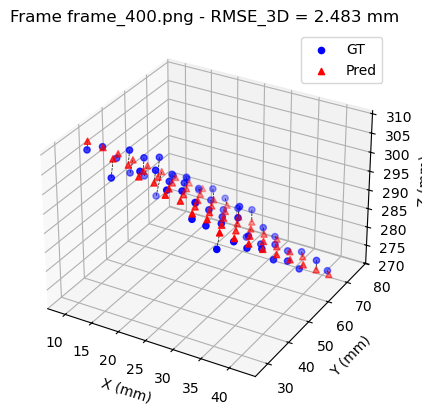

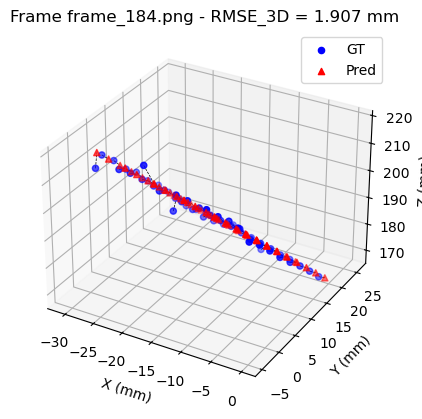

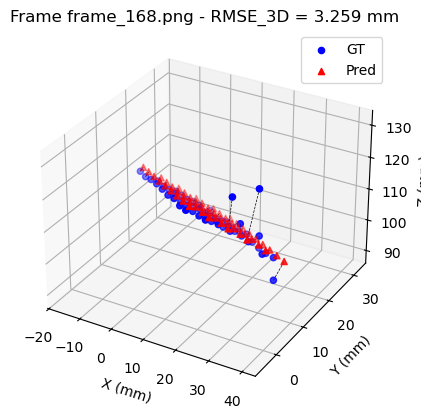

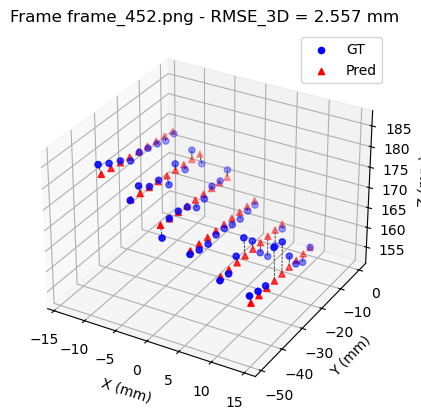

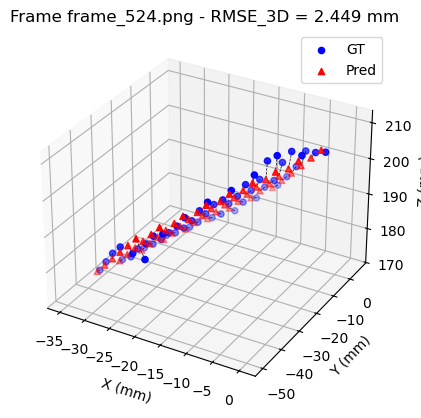

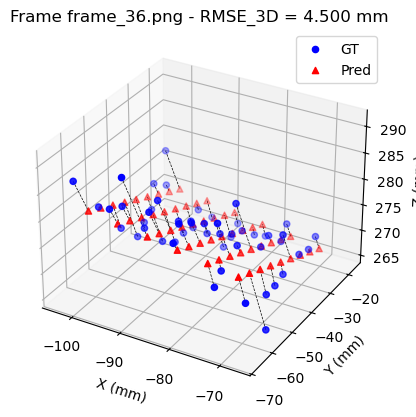

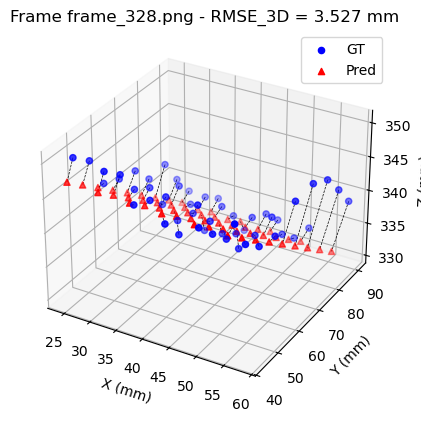

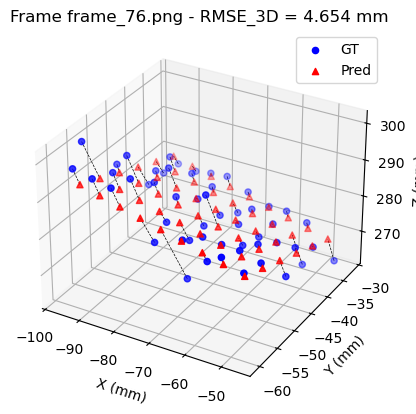

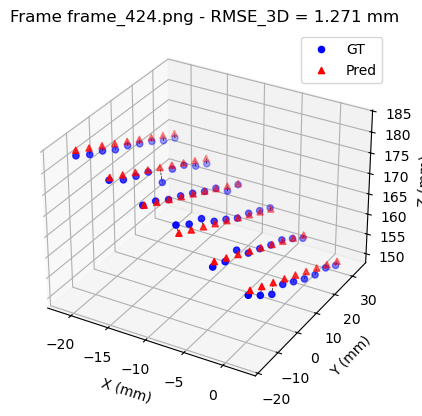

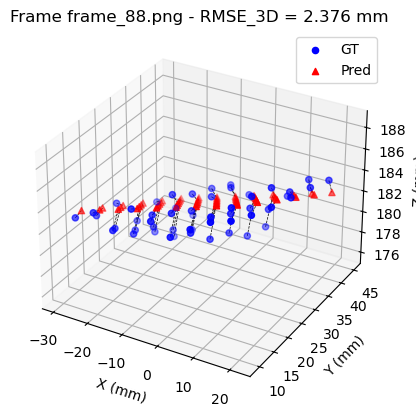

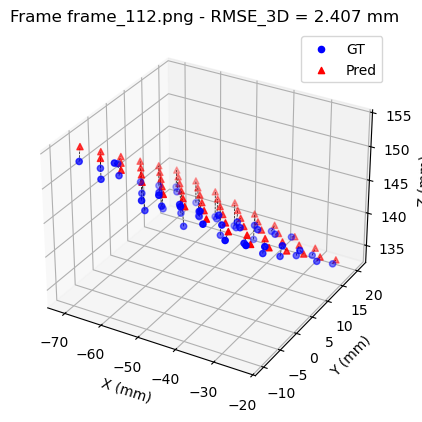

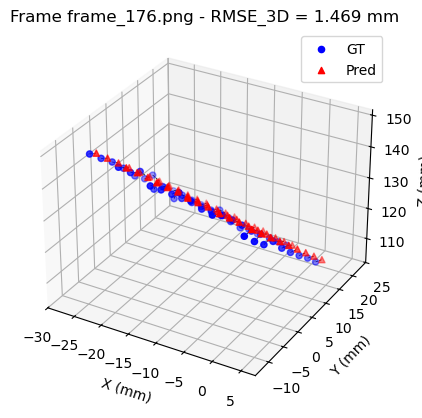

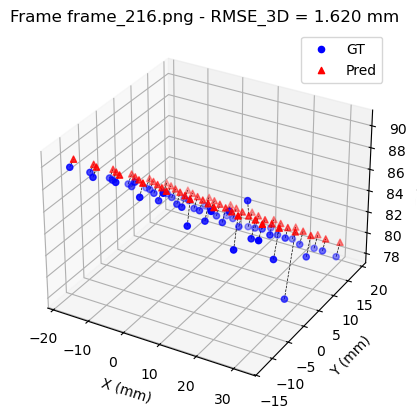

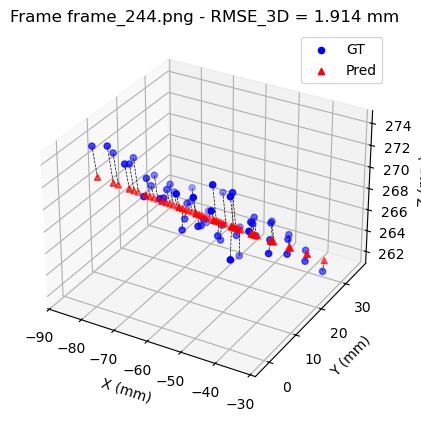

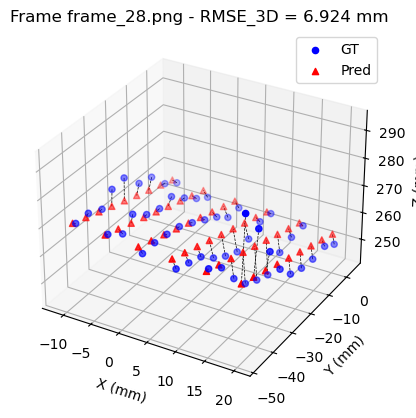

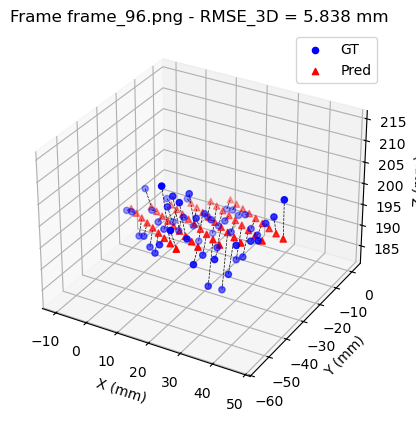

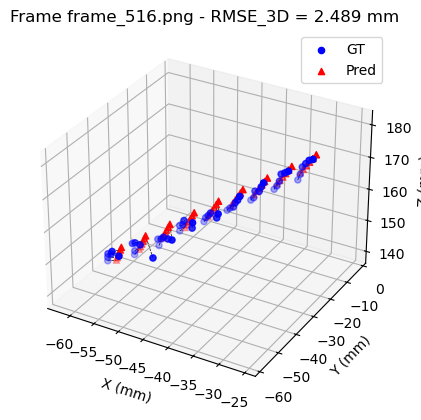

In [18]:
all_rmse_3D_disp= rmse_3D_disp_plot(OT_READINGS,
                                            objpoints,
                                            imgpoints_L,
                                            imgpoints_R,
                                            RECT_TEST_PATH_L,
                                            success_test_frames_L,
                                            CPcb_to_CPot,
                                            BF_to_EN_L_svd,
                                            stereo_params)

print( "total 3D mm error left: {}".format(np.mean(all_rmse_3D_L)) )
